In [1]:
import zipfile
import os
from PIL import Image
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import cv2
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

# Extract Folders From zip Folder:
**The zip folder contains folders each folder have images of the same person from different ages and different views**
url of the dataset collected form Kaggle [link text](https://www.kaggle.com/datasets/hereisburak/pins-face-recognition)

In [2]:
with zipfile.ZipFile('10_classes_pins_dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('dataset')

# Data Cleaning:
**There is no data Cleaning as the data is about face images of persons and i brute forced the folders and checked there is no need to clean the folders**

# Data Preprocessing:
**Create two arrays one for features(x) and one for encoded labels(y) to be used to train and test also there is class indices which map the enconded label with the class name**

In [3]:
def preprocess_image(image_path, target_size=(128, 128)):
    image = Image.open(image_path).convert('RGB')
    image = image.resize(target_size)
    image = np.array(image) / 255.0  # Normalize to [0, 1]
    return image

def load_dataset(dataset_path):
    X, y = [], []
    class_names = sorted(os.listdir(dataset_path))
    class_indices = {name: idx for idx, name in enumerate(class_names)}
    for class_name in class_names:
        class_dir = os.path.join(dataset_path, class_name)
        if os.path.isdir(class_dir):
            for img_name in os.listdir(class_dir):
                img_path = os.path.join(class_dir, img_name)
                if os.path.isfile(img_path):  # Ensure it's a file
                    X.append(preprocess_image(img_path))
                    y.append(class_indices[class_name])
    X = np.array(X)
    y = np.array(y)
    return X, y, class_indices

In [4]:
X, y, class_indices = load_dataset('dataset/105_classes_pins_dataset')

# Plot Sample of the Dataset:
**from each Label get random Feature and its ClassName**

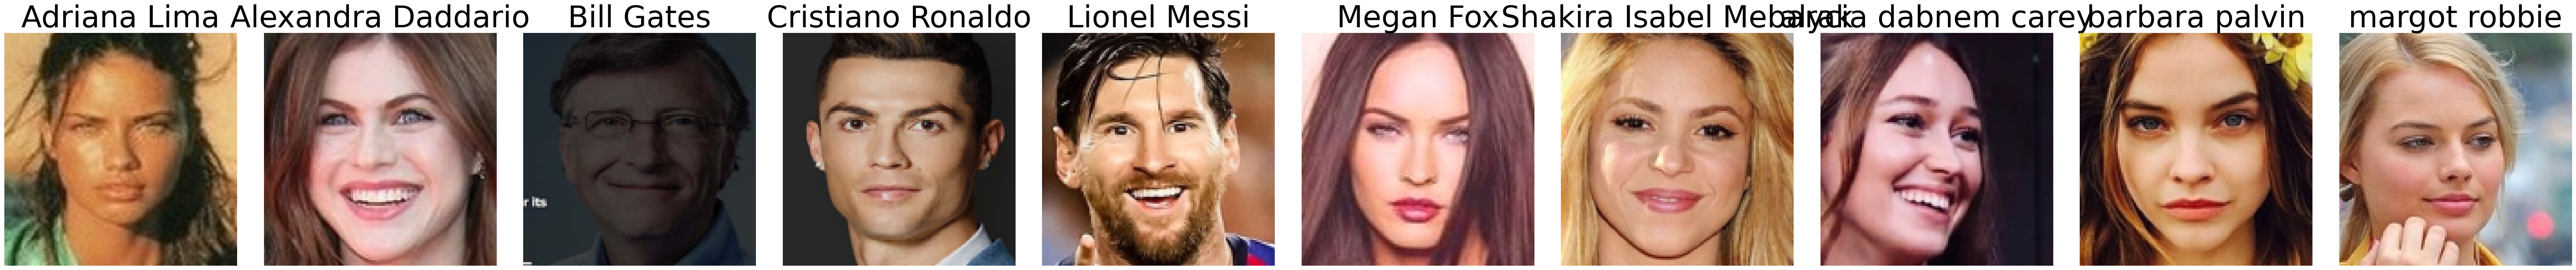

In [5]:
def plot_sample_images_per_class(X, y, class_indices, n_samples=1):
    # Remove 'pins_' prefix from class names
    class_names = [name.replace('pins_', '') for name in class_indices.keys()]
    n_classes = len(class_names)

    # Increase figure size to ensure larger and spaced out images
    fig, axes = plt.subplots(n_samples, n_classes, figsize=(n_classes * 6, n_samples * 6))
    for class_name, class_index in zip(class_names, class_indices.values()):
        class_images = X[y == class_index]
        for i in range(n_samples):
            img = class_images[i]
            ax = axes[i, class_index] if n_samples > 1 else axes[class_index]
            ax.imshow(img)
            ax.set_title(class_name, fontsize=50)
            ax.axis('off')

    plt.tight_layout()
    plt.show()

plot_sample_images_per_class(X, y, class_indices)


# Train and test the dataset:
**Features as X and encoded images Labels as Labels**

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Data augemntation:
****

*  Images can be rotated by up to 20 degrees.

*   They can be shifted horizontally or vertically by up to 20% of their width or height.

*   Random horizontal flips are applied with a 50% probability.
*   Images can be zoomed in by up to 20%.
*Shear transformations can be applied up to 20 degrees.





In [7]:
datagen = ImageDataGenerator(rotation_range=20, width_shift_range=0.2,
                             height_shift_range=0.2, horizontal_flip=True,
                             zoom_range=0.2, shear_range=0.2)

# Feature Extraction with SIFT and Bag-of-Words:


In [8]:
def extract_sift_features(image):
    image = (image * 255).astype(np.uint8)
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    sift = cv2.SIFT_create()
    keypoints, descriptors = sift.detectAndCompute(gray, None)
    return descriptors

sift_descriptors = []
for img in X_train:
    descriptors = extract_sift_features(img)
    if descriptors is not None:
        sift_descriptors.extend(descriptors)

sift_descriptors = np.array(sift_descriptors)


In [9]:
kmeans = KMeans(n_clusters=500, random_state=42).fit(sift_descriptors)
visual_vocabulary = kmeans.cluster_centers_


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [10]:
def compute_bow_histogram(image, kmeans):
    descriptors = extract_sift_features(image)
    if descriptors is None:
        return np.zeros(len(kmeans.cluster_centers_))
    visual_words = kmeans.predict(descriptors)
    histogram, _ = np.histogram(visual_words, bins=np.arange(len(kmeans.cluster_centers_) + 1))
    return histogram

X_train_bow = np.array([compute_bow_histogram(img, kmeans) for img in X_train])
X_test_bow = np.array([compute_bow_histogram(img, kmeans) for img in X_test])

# **Machine Learning with Bag-of-Words Representation:**

#  Support Vector Classifier Using Grid Search for optimizing Hyperparamters
**used C and gamma since they are vital hyperparameters in SVM as:**

*   **C** controls the trade-off between a smooth decision boundary and classifying training points correctly.
*  **gamma** determines the influence of a single training example's distance on the decision boundary.

**these parameters optimizes SVM performance, balancing model complexity and generalization.**





In [11]:
param_grid = {'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001]}
grid = GridSearchCV(SVC(), param_grid, refit=True, verbose=2)
grid.fit(X_train_bow, y_train)

print(f"Best parameters found: {grid.best_params_}")

y_pred = grid.predict(X_test_bow)
print("SVM with Bag-of-Words Representation")
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END .....................................C=0.1, gamma=1; total time=   0.5s
[CV] END .....................................C=0.1, gamma=1; total time=   0.5s
[CV] END .....................................C=0.1, gamma=1; total time=   0.5s
[CV] END .....................................C=0.1, gamma=1; total time=   0.5s
[CV] END .....................................C=0.1, gamma=1; total time=   0.5s
[CV] END ...................................C=0.1, gamma=0.1; total time=   0.5s
[CV] END ...................................C=0.1, gamma=0.1; total time=   0.5s
[CV] END ...................................C=0.1, gamma=0.1; total time=   0.5s
[CV] END ...................................C=0.1, gamma=0.1; total time=   0.5s
[CV] END ...................................C=0.1, gamma=0.1; total time=   0.5s
[CV] END ..................................C=0.1, gamma=0.01; total time=   0.5s
[CV] END ..................................C=0.1

# **Deep Learning with CNN :**
**Using VGG16 model for image classification. It loads the pre-trained VGG16 model, freezes its layers, adds custom fully connected layers, compiles the model, and trains it using augmented data for 20 epochs.**

In [12]:
# CNN using VGG16 with transfer learning
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
base_model.trainable = False

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dense(len(class_indices), activation='softmax')
])


model.summary()


58889256/58889256 [==============================] - 3s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 global_average_pooling2d (  (None, 512)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 256)               131328    
                                                                 
 dense_1 (Dense)             (None, 10)                2570      
                                                                 
Total params: 14848586 (56.64 MB)
Trainable params: 133898 (523.04 KB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [13]:
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = model.fit(datagen.flow(X_train, y_train, batch_size=32),
                    validation_data=(X_test, y_test), epochs=20)

Epoch 1/20
44/44 [==============================] - 364s 8s/step - loss: 2.1026 - accuracy: 0.2248 - val_loss: 1.7413 - val_accuracy: 0.3937
Epoch 2/20
44/44 [==============================] - 365s 8s/step - loss: 1.7437 - accuracy: 0.3710 - val_loss: 1.5529 - val_accuracy: 0.4195
Epoch 3/20
44/44 [==============================] - 354s 8s/step - loss: 1.5541 - accuracy: 0.4697 - val_loss: 1.4216 - val_accuracy: 0.4885
Epoch 4/20
44/44 [==============================] - 409s 9s/step - loss: 1.4168 - accuracy: 0.5101 - val_loss: 1.3501 - val_accuracy: 0.5086
Epoch 5/20
44/44 [==============================] - 372s 9s/step - loss: 1.3323 - accuracy: 0.5295 - val_loss: 1.2350 - val_accuracy: 0.5661
Epoch 6/20
44/44 [==============================] - 364s 8s/step - loss: 1.2760 - accuracy: 0.5706 - val_loss: 1.1857 - val_accuracy: 0.5833
Epoch 7/20
44/44 [==============================] - 323s 7s/step - loss: 1.2376 - accuracy: 0.5598 - val_loss: 1.1124 - val_accuracy: 0.5948
Epoch 8/20
44

# **Model Evaluation:**

*  Computes test loss and accuracy.



---
# **Prediction:**

*  Predicts labels for the test set.
*  Converts predicted probabilities to class labels.


---


# **Classification Report:**

*   Generates a concise classification report with precision, recall, F1-score, and support for each class.

---
# **Training & Validation Metrics Visualization:**


*   Plots training and validation accuracy values.
*   Plots training and validation loss values across epochs.








In [14]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"CNN Model Test Accuracy: {test_acc}")

11/11 [==============================] - 60s 5s/step - loss: 0.9601 - accuracy: 0.6351
CNN Model Test Accuracy: 0.6350574493408203


11/11 [==============================] - 60s 5s/step
Classification Report:
                        precision    recall  f1-score   support

          Adriana Lima       0.52      0.74      0.61        39
    Alexandra Daddario       0.82      0.58      0.68        55
            Bill Gates       1.00      0.97      0.98        30
     Cristiano Ronaldo       0.67      0.67      0.67        18
          Lionel Messi       0.67      0.55      0.60        11
             Megan Fox       0.85      0.56      0.68        39
Shakira Isabel Mebarak       0.63      0.94      0.75        31
   alycia dabnem carey       0.71      0.30      0.42        40
        barbara palvin       0.47      0.50      0.48        44
         margot robbie       0.46      0.68      0.55        41

              accuracy                           0.64       348
             macro avg       0.68      0.65      0.64       348
          weighted avg       0.67      0.64      0.63       348

Confusion Matrix:
[[29  3

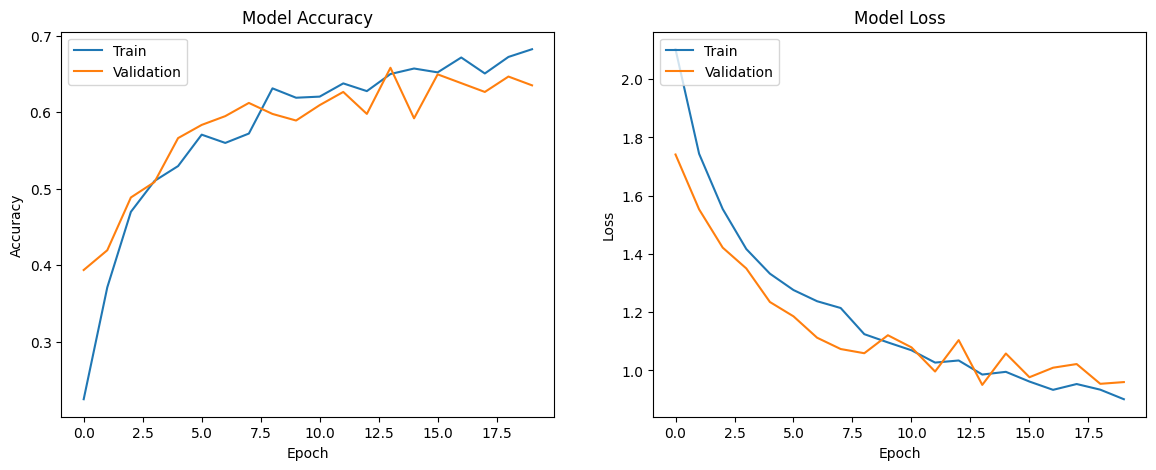

In [15]:
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)


report = classification_report(y_test, y_pred, target_names=[name.replace('pins_', '') for name in class_indices.keys()])
print("Classification Report:")
print(report)


conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)


plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

# **Comparison and Analysis:**

# 1- Performance Comparison:
* The machine learning approach employing the bag-of-words (BoW) representation combined with Support Vector Machine (SVM) achieves a certain level of performance. This method relies on handcrafted features extracted from images using BoW, which captures local visual features effectively. SVMs, known for their ability to handle high-dimensional data and nonlinear relationships well, provide a robust classification framework. However, the performance of this approach may be limited by the need for manual feature engineering and hyperparameter tuning.

* the deep learning approach utilizing Convolutional Neural Networks (CNN), especially with transfer learning from the VGG16 model, offers an alternative for image classification tasks. CNNs automatically learn hierarchical representations from raw pixel data, reducing the reliance on manual feature engineering. This approach excels in capturing complex patterns and spatial dependencies within images, making it highly effective for large-scale datasets with intricate features.

# 2- Strengths and Weaknesses:
1. **Machine Learning with BoW and SVM:**

 **Strengths**:
* Effective for smaller datasets with simpler feature representations.
* BoW captures local visual features well.
* SVMs are known for their ability to handle high-dimensional data and nonlinear relationships effectively.

 **Weaknesses**:
* Limited in capturing complex patterns and hierarchies present in images.
* Performance highly dependent on feature engineering and hyperparameter tuning.
* May struggle with scalability for larger datasets and computational complexity.

2. **Deep Learning with CNN:**

    **Strengths**:
* CNNs automatically learn hierarchical representations from raw pixel data, reducing the need for manual feature engineering.

* Highly effective for large-scale datasets with complex patterns.

* Can capture spatial dependencies and intricate features within images.

    **Weaknesses**:
* Requires large amounts of labeled data for training.
* Computationally intensive, especially for training on large datasets and complex architectures.
* Prone to overfitting, necessitating techniques like dropout and regularization.    

# 3- Scenarios for Hybrid Approach:
**When Combining Both Methods May Be Beneficial:**
* **Limited Data Availability**: If the dataset is small or lacks diversity, using a hybrid approach can leverage the strengths of both methods.

* **Computationally Constrained Environments**: In situations where computational resources are limited, a hybrid approach can strike a balance between accuracy and resource usage.

* **Domain-Specific Tasks**: Certain tasks may benefit from a combination of handcrafted features (e.g., BoW) and learned representations (e.g., CNNs), especially in domains where interpretability of features is crucial.

# 4- Increasing Accuracy:
**Machine Learning Approach (BoW+SVM):**
* use better Optimizer for hyperparameters .
* Explore alternative feature extraction techniques or use more advanced methods.

**Deep Learning Approach (CNN):**
* Fine-tune hyperparameters of the pre-trained VGG16 model or explore other pre-trained architectures for better performance.
* Increase model complexity with deeper architectures or explore ensemble methods.
* Augment the dataset further or use techniques like transfer learning from larger datasets.

# 5- Resource Utilization:

* **The machine learning approach (BoW+SVM) requires less computational resources for training and inference compared to deep learning.**
* **Deep learning with CNN demands powerful GPUs or TPUs for training, especially with large datasets and complex models, so to run this model on full dataset and gain more accuracy it will need more powerful GPU as the runtime for is high**




  













